# Main Goals of the project
- predict 'taxvaluedollarcount'
    - on single unit properties
    - between May and June of 2017
- what states and counties are properties located
- plot distribution of tax rates for each county

For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the property's assessed value, taxvaluedollarcnt. You can expand this to other fields after you have completed an mvp (minimally viable product).

In [2]:
import pandas as pd
from prepare import scale_wrangle_mvp_zillow

### Data Prep
- grabbed all data that had the title single family residential
- dropped all null values for sqrft(24)
- dropped all bedrooms == 0 (18)
- dropped all bathrooms == 0 (4)


In [3]:
train, validate, test = scale_wrangle_mvp_zillow()

In [7]:
train.head()

,sqrft,bedroom,bathroom,taxvalue,sqrft_scaled,bedroom_scaled,bathroom_scaled
13700,1122.0,3.0,1.0,69246.0,0.054257,0.181818,0.000000
13662,3794.0,3.0,3.5,1600000.0,0.230627,0.181818,0.277778
4257,1541.0,3.0,1.0,130067.0,0.081914,0.181818,0.000000
1486,1207.0,2.0,1.0,274868.0,0.059868,0.090909,0.000000
6746,2247.0,3.0,3.0,431695.0,0.128515,0.181818,0.222222


### Data Exploration

#### Is tax value independent from the amount of bedrooms?

##### Hypothesis 1:

$H_0$: Tax value and the amount of bedrooms are **independent**

$H_a$: Tax value and the amount of bedrooms are **dependent**


In [10]:
from scipy import stats

In [14]:
x = train.bedroom
y = train.taxvalue

In [15]:
alpha = .05

In [12]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.2669555883591621, 1.3769600444111775e-146)

In [13]:
print('Correlation between tax value and bedrooms')
print(f'  r = {corr:.3f}')

Correlation between tax value and bedrooms
  r = 0.267


In [16]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


1.3769600444111775e-146

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
def plot_variable_pairs(df, drop_scaled_columns = True):
    '''
    This function takes in a DataFrame and plots all of the 
    pairwise relationships along with the regression line for each pair.
    '''
    if drop_scaled_columns:
        scaled_columns = [c for c in df.columns if c.endswith('_scaled')]
        df = df.drop(columns = scaled_columns)
    #to see all the plots at once, pairplot but with more customizations
    g = sns.PairGrid(df)
    #the plots is the diagonal will be a distribution plot
    g.map_diag(plt.hist) #one for a single variable
    #the plots not in the diagonal will be a scatter plot
    g.map_offdiag(sns.regplot) #one for the interaction of two variables
    plt.show()
    return g

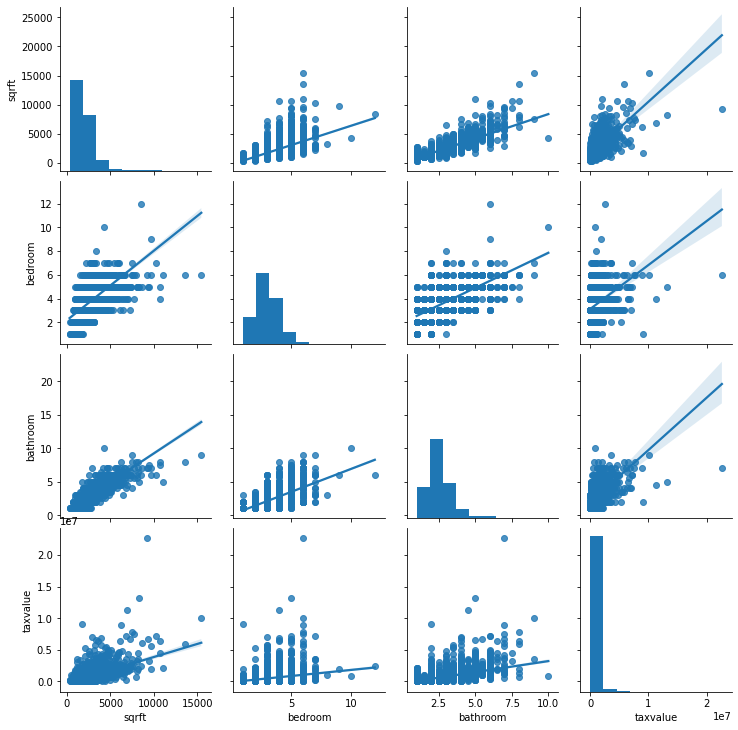

In [32]:
plot_variable_pairs(train)